# Linear Classification

# SVM, LR , calibration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [238]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.compose import ColumnTransformer

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [239]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?

**Ответ:** Уже в коде можно заметить ключевое слово - `predict_proba`. То есть вместо предсказание классов мы предсказываем вероятности принадлежности к классу. Это нужно для калибровки вероятностей - после того, как предсказали вероятности, мы выбираем такой порог, чтобы верояности наиболее подпадали под классы.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [240]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
#Для разделяющей прямой
from mlxtend.plotting import plot_decision_regions


from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


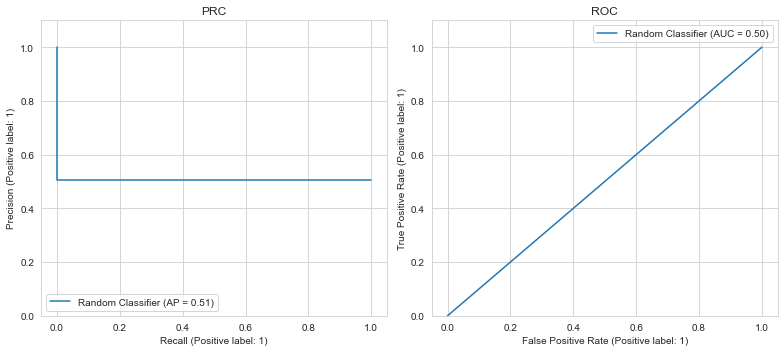

In [241]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [242]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [243]:
def AUC_PR(y, y_pred):
    precision, recall, _ = precision_recall_curve(y, y_pred)
    return auc(recall, precision)
    

In [244]:
auc_scorer = make_scorer(AUC_PR)
range_C = np.linspace(1e-4, 1,20)

In [245]:
%%time
searcher_svm = GridSearchCV(LinearSVC(max_iter=100000, random_state=42), param_grid=[{"C": range_C}], scoring=auc_scorer, cv=10)
searcher_svm.fit(X_train, y_train)
svm_best_C = searcher_svm.best_params_["C"]
print("Лучший параметр регуляризации C равен {}".format(round(svm_best_C, 5)))

Лучший параметр регуляризации C равен 0.05273
Wall time: 2min 21s


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [246]:
svc = LinearSVC(max_iter=100000, random_state=42, C=svm_best_C).fit(X_train, y_train)
pred_svm = svc.decision_function(X_test)

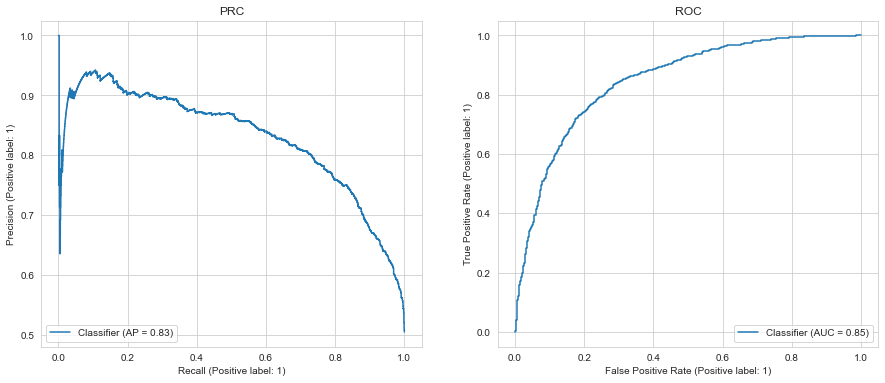

In [247]:
fig, ax = plt.subplots(1, 2, figsize=(15,6 ))

PrecisionRecallDisplay.from_predictions(y_test, pred_svm, ax = ax[0]);
ax[0].set_title("PRC");
RocCurveDisplay.from_predictions(y_test, pred_svm, ax=ax[1]);
ax[1].set_title("ROC");

In [248]:
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.75283


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [249]:
df_metrics.loc['SVM Classifier'] = [
    AUC_PR(y_test, pred_svm),
    roc_auc_score(y_test, pred_svm),
    svm_best_C
]

In [250]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.829681,0.847647,0.052726


Значения выросли значительно, особенно для AUC_ROC (на 34 у.е.), AUC_PR на 7 у.е.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [251]:
searcher_lr = GridSearchCV(LogisticRegression(max_iter=100000, random_state=42), param_grid=[{"C": range_C}], scoring=auc_scorer , cv=10)

searcher_lr.fit(X_train, y_train)

logreg_best_C = searcher_lr.best_params_["C"]
print("Лучший параметр регуляризации C равен {}".format(round(logreg_best_C, 5)))


Лучший параметр регуляризации C равен 0.05273


In [253]:
logreg = LogisticRegression(max_iter=100000, random_state=42, C=logreg_best_C).fit(X_train, y_train)
y_pred_logreg = logreg.decision_function(X_test)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

AUC-PR : 0.82928
AUC-ROC: 0.84783


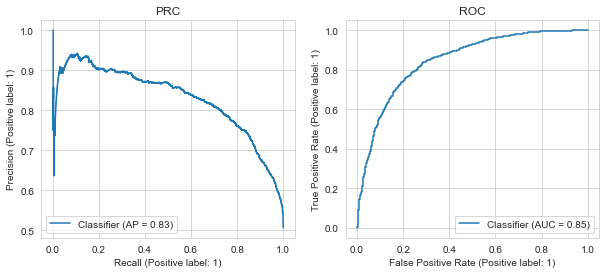

In [254]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

PrecisionRecallDisplay.from_predictions(y_test, y_pred_logreg, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred_logreg)

precision, recall, _ = precision_recall_curve(y_test, y_pred_logreg)
print("AUC-PR : {}".format(round( auc(recall, precision), 5)) )
ax[0].set_title("PRC")


RocCurveDisplay.from_predictions(y_test, y_pred_logreg, ax=ax[1])
print("AUC-ROC: {}".format( round( roc_auc_score(y_test, y_pred_logreg), 5) ) )
ax[1].set_title("ROC");

In [255]:
df_metrics.loc['LR Classifier'] = [
    AUC_PR(y_test, y_pred_logreg),
    roc_auc_score(y_test, y_pred_logreg),
    logreg_best_C
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.829681,0.847647,0.052726
LR Classifier,0.829282,0.847826,0.052726


In [256]:
df_metrics.sort_values('AUC_PR')

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
LR Classifier,0.829282,0.847826,0.052726
SVM Classifier,0.829681,0.847647,0.052726


In [257]:
df_metrics.sort_values('AUC_ROC')

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVM Classifier,0.829681,0.847647,0.052726
LR Classifier,0.829282,0.847826,0.052726


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Различия между методом опорных векторов и логистической регрессией не значительны (заметны примерно после 4 знака после запятой). `AUC PR` больше чуть больше у логистической регресси , `AUC ROC` больше у опорных векторов. В то время как параметр регуляризации совпал. 

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [258]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Нарисуем разделяющую прямую [идея отсюда](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/). 

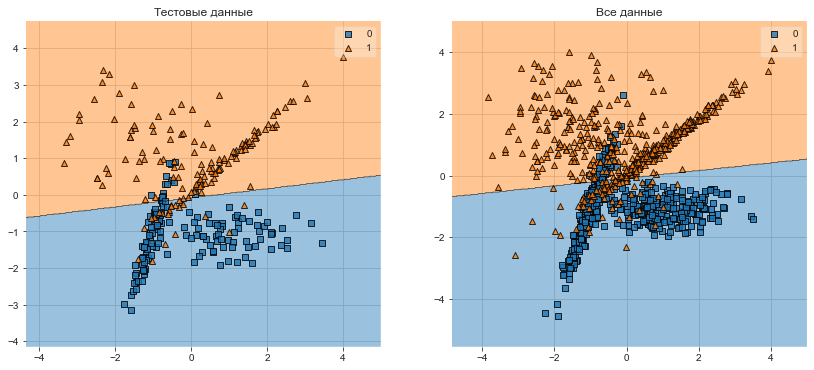

In [259]:
svc = SVC(kernel='linear', C=svm_best_C, random_state=42).fit(X_train, y_train)

fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
plot_decision_regions(X_test, y_test, svc, ax=axs[0])

axs[0].set_title("Тестовые данные");

plot_decision_regions(X, y, svc, ax=axs[1])

axs[1].set_title("Все данные");

In [23]:
logreg = LogisticRegression(max_iter=100000, random_state=42, C= logreg_best_C).fit(X_train, y_train)



В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** В виде белой зоны (я бы даже сказал линии). Она находится очень близко к разделяющей прямой. То есть эти значения почти являются так называеми 0 (где есть классы +1 и -1), где модели сложно решить к какому классу их причислить (малая уверенность т к малое расстояние от разделяющей прямой).

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [260]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        # error ("+" not "-")
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [261]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

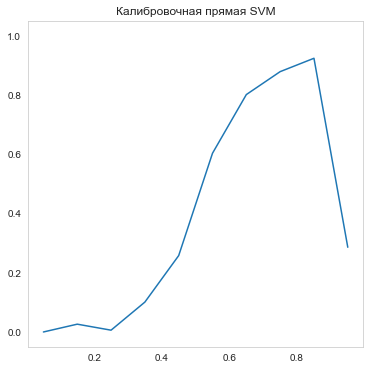

In [262]:
svc = SVC(kernel='linear', C=svm_best_C, random_state=42).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)

svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

plot_calibration_curve(y_test, svc_pred)
plt.title('Калибровочная прямая SVM');

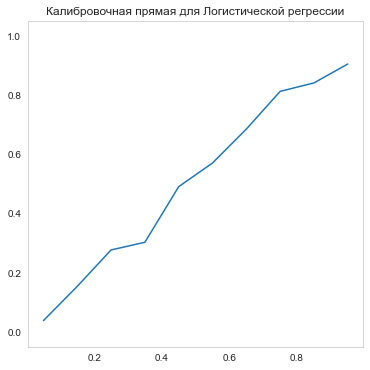

In [263]:
logreg = LogisticRegression(max_iter=100000, random_state=42, C=logreg_best_C).fit(X_train, y_train)

logreg_pred = logreg.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, logreg_pred)
plt.title('Калибровочная прямая для Логистической регрессии');

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** SVM калибровка выглядит очень плачевно, далеко от идеального варианта, калибровка логистической регрессии выглядит значительно лучше.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

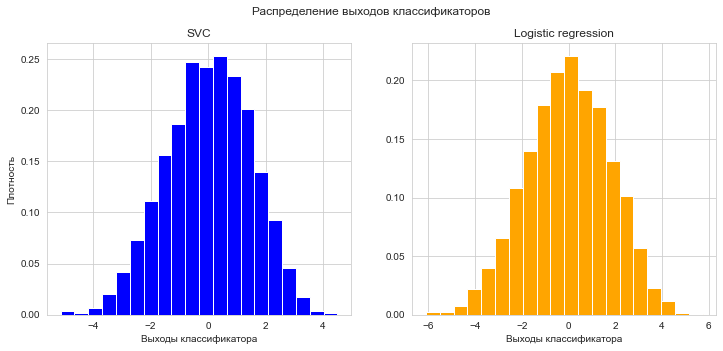

In [264]:
#из семинара 6
svc_pred = svc.decision_function(X_test)
logreg_pred = logreg.decision_function(X_test)

sns.set_style('whitegrid')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(logreg_pred, bins=20, color='orange', density='True')

axs[0].set_xlabel('Выходы классификатора')
axs[1].set_xlabel('Выходы классификатора')

axs[0].set_ylabel('Плотность')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение выходов классификаторов');

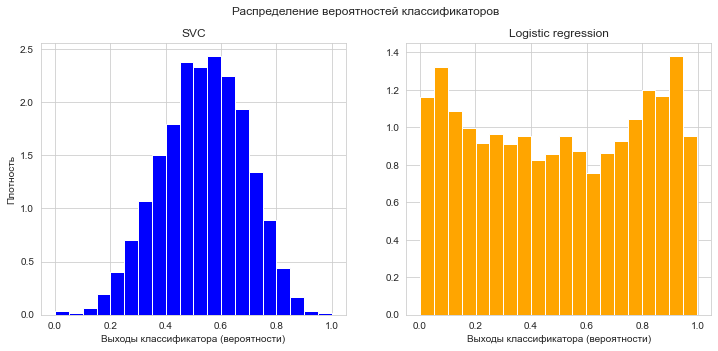

In [265]:
# из семинара 6
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
logreg_pred = logreg.predict_proba(X_test)[:, 1]

sns.set_style('whitegrid')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(logreg_pred, bins=20, color='orange', density='True')

axs[0].set_xlabel('Выходы классификатора (вероятности)')
axs[1].set_xlabel('Выходы классификатора (вероятности)')

axs[0].set_ylabel('Плотность')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение вероятностей классификаторов');

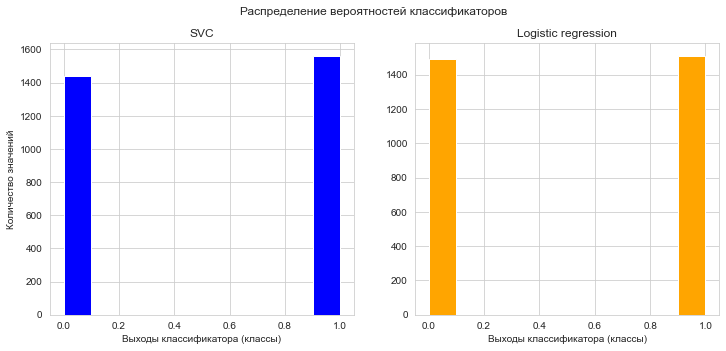

In [266]:

y_pred_svc = svc.predict(X_test)
y_pred_logreg = logreg.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(y_pred_svc, color='blue')
axs[1].hist(y_pred_logreg, color='orange')

axs[0].set_xlabel('Выходы классификатора (классы)')
axs[1].set_xlabel('Выходы классификатора (классы)')

axs[0].set_ylabel('Количество значений')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение вероятностей классификаторов');

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Предсказания моделей отчасти напоминают *нормальное распределение*. SVC также дает нам *нормальное распределение*. В то время как логистическая регрессия дает скорее равномерное распределения с двумя *башенками* хвостами по бокам. Что логично, т к логистическая регрессия стремиться максимизировать вероятность приандлежности к классу, по этому при приближении к распреляющей прямой модель начинает сомневаться. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [267]:

calibration_svc = CalibratedClassifierCV(SVC(kernel='linear'), method='sigmoid', cv=10)
calibration_svc.fit(X_train, y_train)
svc_pred_calibrated = calibration_svc.predict_proba(X_test)[:,1]
svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred_calibrated, n_bins=10)


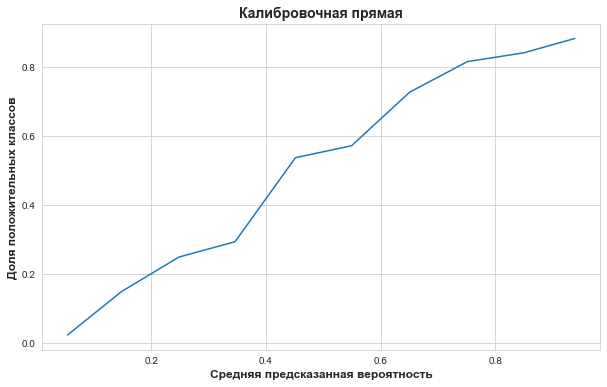

In [278]:
fig, ax = plt.subplots( figsize=(10,6 ))
sns.lineplot(x= svc_pred_prob,y= svc_true_prob, ax = ax);
plt.xlabel('Средняя предсказанная вероятность',  fontsize=12, fontweight="bold")
plt.ylabel('Доля положительных классов',  fontsize=12, fontweight="bold")
plt.title('Калибровочная прямая',  fontsize=14, fontweight="bold");

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да, произошло значительное улучшение, близкое к идеалу

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [269]:
#Допустим это можно было делать
from scipy.optimize import minimize

__Идея__: 

Шкалирование Платта (Platt), запишем его в формальном виде

$ P(y=1 | f) = \frac{1}{1 + exp(w \cdot f + \beta)} $

где f выходные оценки модели, w и beta - коэффициенты логистической регрессии. 

В [оригинале](https://en.wikipedia.org/wiki/Platt_scaling#:~:text=In%20machine%20learning%2C%20Platt%20scaling,a%20probability%20distribution%20over%20classes) А и B, но я слишком привык к w и $\beta$ потому возьму их.

Самое главное происходит в logistic_loss, где А и B оцениваются c помощью метода максимального правдоподобия.

In [283]:
class PlattScalingCalibrator:
    def __init__(self):
        self.beta = 0
        self.w = 0

    # Минимизация logistic loss 
    def logistic_loss(self, params, f, y):
        beta, w = params
        y_prob = 1 / (1 + np.exp(beta * f + w))
        return - np.sum(np.log(y_prob[y == 1])) - np.sum(np.log(1 - y_prob[y == 0]))
    #Фитим
    def fit(self, f, y):
        params = np.array([0.0, 0.0])  
        res = minimize(self.logistic_loss, params, args=(f, y), method='L-BFGS-B')
        self.beta, self.B = res.x

    # Предиктим 
    def predict_proba(self, f):
        return 1 / (1 + np.exp(self.beta * f + self.w))

In [284]:
calibrator = PlattScalingCalibrator()
calibrator.fit(X_train, y_train)
calibrated_probs = calibrator.predict_proba(X_test)[:,1]
true_prob, pred_prob = calibration_curve(y_test, calibrated_probs, n_bins=10)

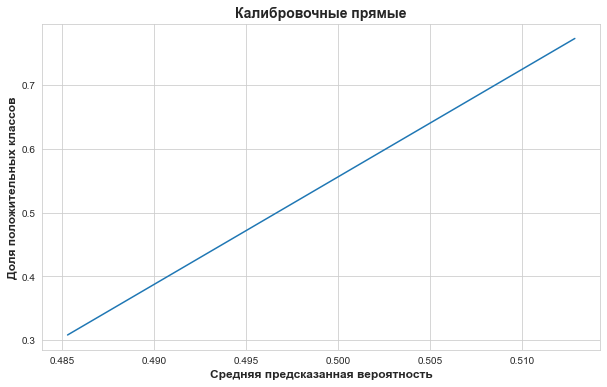

In [285]:
fig, ax = plt.subplots( figsize=(10,6 ))
sns.lineplot(x= pred_prob,y= true_prob, ax = ax);
plt.xlabel('Средняя предсказанная вероятность',  fontsize=12, fontweight="bold")
plt.ylabel('Доля положительных классов',  fontsize=12, fontweight="bold")
plt.title('Калибровочные прямые',  fontsize=14, fontweight="bold");

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [33]:
df = pd.read_csv('bike_buyers.csv')


X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')




In [34]:
df[['Children', 'Cars']].describe().T

,count,mean,std,min,25%,50%,75%,max
Children,992.0,1.910282,1.626910,0.0,0.0,2.0,3.0,5.0
Cars,991.0,1.455096,1.121755,0.0,1.0,1.0,2.0,4.0


In [35]:
df['Commute Distance'].value_counts()

0-1 Miles     366
5-10 Miles    192
1-2 Miles     169
2-5 Miles     162
10+ Miles     111
Name: Commute Distance, dtype: int64

In [38]:


X_numerical = df[['Income',  'Age', 'Children', 'Cars']]
X_categorical = df[['Marital Status', 'Gender','Education',
       'Occupation', 'Home Owner', 'Region', 'Commute Distance'  ]]
X_categorical.fillna('undefined', inplace = True)

В начале поработаем только с категориальными признаками

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [43]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

In [44]:
column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), X_train.columns)
])

pipeline = Pipeline(steps=[
    ('ordinal', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=42))
])

In [45]:
np.random.seed(42)

start = time.process_time()
model = pipeline.fit(X_train, y_train)

finish = time.process_time()

delta_time = finish - start

pred = model.decision_function(X_test)

auc_log_reg = AUC_PR(y_test, pred)

print("Качество (AUC-PR) равно {},\nВремя расчета составило {} секунд"\
.format(round(auc_log_reg, 5), delta_time))

Качество (AUC-PR) равно 0.57894,
Время расчета составило 0.0 секунд


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [46]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), X_train.columns)
])
pipeline = Pipeline(steps = [
    ('ohe', column_transformer),
    ('regression', LogisticRegression(max_iter= 100000, random_state=13) )
])

In [47]:
np.random.seed(42)

start = time.process_time()
model = pipeline.fit(X_train, y_train)
finish = time.process_time()
delta_time = finish - start
pred = model.decision_function(X_test)
auc_log_reg = AUC_PR(y_test, pred)
print("Качество (AUC-PR) равно {},\nВремя расчета составило {} секунд"\
.format(round(auc_log_reg, 5), delta_time))

Качество (AUC-PR) равно 0.66186,
Время расчета составило 0.03125 секунд


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [48]:
def mean_target_encoding(X_train, X_test, y_train, feature_name):
    data = X_train.copy()
    data['y'] = y_train

    mean_encoded = data.groupby(feature_name)['y'].mean()
    X_train[feature_name + '_mte'] = X_train[feature_name].map(mean_encoded)
    X_test[feature_name + '_mte'] = X_test[feature_name].map(mean_encoded)
    X_train = X_train.drop([feature_name], axis=1)
    X_test = X_test.drop([feature_name], axis=1)
    return X_train, X_test

In [49]:
new_features = list(map(lambda x: x + '_mte', X_train.columns))

In [50]:
np.random.seed(42)

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

start_time1 = time.process_time()  

for column in X_train.columns:
    X_train_encoded, X_test_encoded = mean_target_encoding(X_train_encoded, X_test_encoded, y_train, column)
    
lr_mte = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_encoded, y_train)
finish = time.process_time()

delta_time = finish - start

y_pred_lr = lr_mte.decision_function(X_test_encoded)
auc_pr_lr = AUC_PR(y_test, y_pred_lr)

print("Качество на тесте (AUC-PR) равно {},\nВремя расчета  {} секунд"\
.format(round(auc_pr_lr, 5), delta_time))
pred_lr = lr_mte.decision_function(X_train_encoded)
auc_pr_lr = AUC_PR(y_train, pred_lr)
print("Качество на трейне (AUC-PR) равно {}"\
.format(round(auc_pr_lr, 5), delta_time))

Качество на тесте (AUC-PR) равно 0.65269,
Время расчета  0.09375 секунд
Качество на трейне (AUC-PR) равно 0.63193


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [51]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)



Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

Переберем несколько значений станданртных отклонений

In [52]:
np.random.seed(42)

scales = np.linspace(0.01, 1, 20)
auc_prs = []

for scale in scales:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    
    for column in X_train.columns:
        X_train_encoded, X_test_encoded = mean_target_encoding(X_train_encoded, X_test_encoded, y_train, column)
        
    for new_feature in X_train_encoded.columns:
        X_train_encoded[new_feature] = X_train_encoded[new_feature] + np.random.normal(loc=0, scale=scale, size=X_train_encoded.shape[0])
        X_test_encoded[new_feature] = X_test_encoded[new_feature] + np.random.normal(loc=0, scale=scale, size=X_test_encoded.shape[0])
        
    noisy_logistic_reg = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_encoded, y_train)
    log_reg_noise = noisy_logistic_reg .decision_function(X_test_encoded)
    auc_pr_lr = AUC_PR(y_test, log_reg_noise)

    auc_prs.append(auc_pr_lr)

In [53]:
best_idx = np.argmax(auc_prs)
print("Лучшее значение стандартного отклонения равно {}\
\nЛучшее качество на test (AUC-PR) равно {}.\nЭто на {} лучше"\
      .format( scales[best_idx], round(auc_prs[best_idx], 5), round(0.65269-round(auc_prs[best_idx], 5), 5) ))

Лучшее значение стандартного отклонения равно 0.01
Лучшее качество на test (AUC-PR) равно 0.64953.
Это на 0.00316 лучше


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Не сильно лучше, самое оптимальное значение шума и стандартного отклонения - наименьшее, то есть нет особо сильного переобучения. Идея привнести шум возможно не работает, т к данных не так много. 

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [54]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [55]:
def smooth_mean_target_encoding(X_train, X_test, y_train, feature_name, C=10):
    data = X_train.copy()
    data['y'] = y_train
    mean_global = data['y'].mean()

    counts = data.groupby(feature_name)['y'].count()
    means = data.groupby(feature_name)['y'].mean()
    smooth = (counts * means + C * mean_global) / (counts + C)

    X_train[feature_name+'_s_mte'] = X_train[feature_name].map(smooth)
    X_test[feature_name+'_s_mte'] = X_test[feature_name].map(smooth)
    X_train = X_train.drop([feature_name], axis=1)
    X_test = X_test.drop([feature_name], axis=1)
    return X_train, X_test

In [56]:
smoothed_features  = list(map(lambda x: x + '_s_mte', X_train.columns))

pipeline = Pipeline(steps=[
    #('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [57]:
np.random.seed(42)


X_train_smooth_encoded = X_train.copy()
X_test_smooth_encoded = X_test.copy()

start = time.process_time() 

for column in X_train.columns:
    X_train_smooth_encoded, X_test_smooth_encoded = smooth_mean_target_encoding(X_train_smooth_encoded,
                                                                                X_test_smooth_encoded,
                                                                                y_train, column)



model = pipeline.fit(X_train_smooth_encoded, y_train)
finish = time.process_time()

delta_time = finish - start

pred_smooth = model.decision_function(X_test_smooth_encoded)
auc_pr_lr = AUC_PR(y_test, pred_smooth)
    
print("Качество на test (AUC-PR) составило: {}\
\nВремя расчетов {}  в секундах"\
.format(round(auc_pr_lr, 5), delta_time))

Качество на test (AUC-PR) составило: 0.66974
Время расчетов 0.046875  в секундах


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [58]:
X_numerical = X_numerical.fillna(X_numerical.mean())

In [59]:
X = pd.concat([X_numerical, X_categorical], axis=1 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
print(X.shape, y.shape)

(1000, 11) (1000,)


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [60]:
def unique_count(df, feature):
    print('У числового призанка "{}"  {} уникальных значений'\
          .format( feature,   len(df[feature].unique())    ) )

In [61]:
for feature in X_numerical.columns:
    unique_count(X_numerical, feature)
    

У числового призанка "Income"  17 уникальных значений
У числового призанка "Age"  54 уникальных значений
У числового призанка "Children"  7 уникальных значений
У числового призанка "Cars"  6 уникальных значений


In [62]:
new_smoothed_categorical_features = list(map(lambda x: x + '_s_mte', X_numerical.columns))



pipeline = Pipeline(steps=[
    #('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [63]:
columns = new_smoothed_categorical_features + smoothed_features

np.random.seed(42)
X_train_smooth_encoded = X_train.copy()
X_test_smooth_encoded = X_test.copy()
y_train_new = y_train[:]
y_test_new = y_test[:]

start = time.process_time()

for column in X_train.columns:
     X_train_smooth_encoded, X_test_smooth_encoded = smooth_mean_target_encoding(
         X_train_smooth_encoded, X_test_smooth_encoded, y_train_new, column)
    
X_test_smooth_encoded = X_test_smooth_encoded.dropna()
y_test_new = y_test_new[X_test_smooth_encoded.index]

model = pipeline.fit(X_train_smooth_encoded, y_train_new)

finish = time.process_time()
delta_time = finish - start

pred_smooth_mte = model.decision_function(X_test_smooth_encoded)
auc_pr_lr = AUC_PR(y_test_new, pred_smooth_mte)



print("Качество на test (AUC-PR) составило: {}\
\nПотраченное время {}"\
     .format(round(auc_pr_lr, 5), delta_time))

Качество на test (AUC-PR) составило: 0.66542
Потраченное время 0.09375


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ здесь не только, что я заметил при выполнении конкретного номера, но и в общем

плюсы :
 - Сохранение информации о распределии переменной
 - Робастность (устойчивость) к размеру данных (у one-hot кодирование напротив возникате разреженность)
 
минусы:
 - Угроза переобучения - особенно если мало уникальных значений (у нас с этим как раз проблемы не возникло)
 - Более сложная интерпретация - особенно если переменная напрямую влияет на таргет 

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [64]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



In [208]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
10517,36,Private,177616,5th-6th,3,Separated,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [209]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.income, test_size=0.25, stratify=df.income, random_state=777)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24420, 14), (24420,), (8141, 14), (8141,))

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [210]:
categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric_features = list(X_train.dtypes[X_train.dtypes == "int64"].index)

ohe = OneHotEncoder()

X_train_ohe = ohe.fit_transform(X_train[categorical_features])
X_test_ohe = ohe.transform(X_test[categorical_features])
print("Получили {} новых признаков".format(X_train_ohe.shape[1] - X_train.shape[1]))

Получили 88 новых признаков


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [211]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

In [212]:
np.random.seed(42)



X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

model_base = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_transformed, y_train)

y_pred_base = model_base.decision_function(X_test_transformed)
auc_pr_lr = AUC_PR(y_test, y_pred_base)

print('Качество (AUC-PR) составило :{}'.format( round(auc_pr_lr, 5)) )

Качество (AUC-PR) составило :0.76713


Запомним этот порог **0.7671**

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [213]:
def top_40_features(model, X_train_derive, X_test_derive):
    coef_dict = {}
    for i, w in  enumerate(model.coef_[0]):
        coef_dict[i] = w
    bad_features_list = []
    
    for k, v in coef_dict.items():
        if np.abs(v) not in np.sort(np.abs(model.coef_[0]))[::-1][:40]:
            bad_features_list.append(k)
    best_feature_idx = list(coef_dict.keys())
    
    return X_train_derive[:, best_feature_idx], X_test_derive[:, best_feature_idx], best_feature_idx
    

In [214]:
X_train_best, X_test_best, best_feature_idx = top_40_features(model_base, X_train_transformed, X_test_transformed)

len(best_feature_idx)

108

Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [61]:
#your code here

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [118]:
#your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [119]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [215]:
X_train_new, X_val, y_train_new, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train)

In [216]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

In [217]:
X_train_new_scaled = column_transformer.fit_transform(X_train_new)
X_val_scaled = column_transformer.transform(X_val)
X_test_scaled = column_transformer.transform(X_test)

logreg = LogisticRegression(max_iter=100000, random_state=42).fit(X_train_new_scaled, y_train_new)

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [224]:
quality = []
test_quality = []
idx_best = [i for i in range(X_train_new_scaled.shape[1])]

start = time.process_time() 

while len(idx_best) > 40:
    quality = []
    for i in idx_best:
        new_list = idx_best[:] 
        new_list.remove(i) 
        
        new_logreg = LogisticRegression(max_iter=100000, random_state=42)
        new_logreg.fit(X_train_new_scaled[:, new_list], y_train_new)
        y_pred = new_logreg.decision_function(X_val_scaled[:, new_list])
        auc_pr_value = AUC_PR(y_val, y_pred)
        quality.append(auc_pr_value)
        
    bad_idx = np.argmax(quality)
    idx_best.remove(idx_best[bad_idx])
    
    test_logreg = LogisticRegression(max_iter=100000, random_state=42)
    test_logreg.fit(X_train_new_scaled[:, idx_best], y_train_new)
    y_pred = test_logreg.decision_function(X_test_scaled[:, idx_best])
    auc_pr_value = AUC_PR(y_test, y_pred)
    test_quality.append(auc_pr_value)
    
    
        
finish = time.process_time()
delta = finish - start


print("Время отбора составило {} минут".format(round(delta /60)) )

Время отбора составило 32 минут


In [227]:
test_logreg = LogisticRegression(max_iter=100000, random_state=42)
test_logreg.fit(X_train_new_scaled[:, idx_best], y_train_new)
y_pred = test_logreg.decision_function(X_test_scaled[:, idx_best])
auc_pr_value = AUC_PR(y_test, y_pred)

print('Качество (AUC-PR) после составило:', round(auc_pr_value, 5))

Качество (AUC-PR) после составило: 0.76393


In [228]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

X_train_new_scaled = column_transformer.fit_transform(X_train_new)
X_val_scaled = column_transformer.transform(X_val)
X_test_scaled = column_transformer.transform(X_test)

logreg = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_new_scaled, y_train_new)

In [231]:
quality = []
test_quality = []
idx_best = []
all_features = [i for i in range(X_train_new_scaled.shape[1])]

start = time.process_time()  

while len(idx_best) < 40:
    quality = []
    for i in all_features:
        new_list = all_features[:]
        new_list.remove(i)  
        
        new_logreg = LogisticRegression(max_iter=100000, random_state=42)
        new_logreg.fit(X_train_new_scaled[:, new_list], y_train_new)
        y_pred = new_logreg.decision_function(X_val_scaled[:, new_list])
        auc_pr_values = AUC_PR(y_val, y_pred)

        quality.append(auc_pr_values)
        
    good_idx = np.argmin(quality) 
    idx_best.append(all_features[good_idx])     
    all_features.remove(all_features[good_idx])
    
    test_logreg = LogisticRegression(max_iter=100000, random_state=42)
    test_logreg.fit(X_train_new_scaled[:, idx_best], y_train_new)
    y_pred = test_logreg.decision_function(X_test_scaled[:, idx_best])
    auc_pr_values = AUC_PR(y_test, y_pred)
    test_quality.append(auc_pr_values)

finish = time.process_time()
delta = finish - start

print("Время отбора составило {} минут".format(round(delta /60)) )

Время отбора составило 24 минут


In [234]:
test_logreg = LogisticRegression(max_iter=100000, random_state=42)
test_logreg.fit(X_train_new_scaled[:, idx_best], y_train_new)
y_pred = test_logreg.decision_function(X_test_scaled[:, idx_best])
auc_pr_values_final = AUC_PR(y_test, y_pred)

print('Качество (AUC-PR) после составило:', round(auc_pr_values_final, 5))

Качество (AUC-PR) после составило: 0.66953


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Первый алгоритм оказался лучше (примерно на на 1 сотую), чем второй, хоть и работал чуть дольше (примерно на 8 минут). Мысли по чему так:
 - Шкалирование признаков и так работает весьма эффективно
 - Именно one-hot кодирование дало лучшие результаты, хотя и долговато - нас спасало, что данные не столь большы и не так много категорий
Методы обертки в общем работают очень долго (~не позволительно с точки зрения дедлайна в 23.59~)

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [72]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
# скачал руками
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [73]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [74]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [75]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [76]:
categorical_features = list(X.dtypes[X.dtypes == "object"].index)
numeric_features = list(X.dtypes[(X.dtypes == "int64") | (X.dtypes == "float64")].index)


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=42))
])

In [77]:
metrics = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.decision_function(X_test)
    auc_pr_logreg = AUC_PR(y_test, y_pred)

    metrics.append(auc_pr_logreg)

In [78]:
print(metrics)

[0.4558002846362144, 0.45139198424272886, 0.41615814932931133, 0.4692382692160719, 0.4636211408671181]


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [80]:
profit =[]
call_operator = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    profit.append(precision * y_pred.sum() * 10)
    call_operator.append(y_pred.sum())
    


In [96]:
print("Средняя выручка: ", np.mean(profit))
print("Стандартное отклонение выручки:", round(np.std(profit), 3) )
print("В среднем нужно отдать операторам колл центра: ", np.mean(call_operator))
print("Стандартное отклонение выплат операторам", round(np.std(call_operator), 3))
print("Выручка операторам по фолдам", call_operator)
print("Остаток", np.mean(profit) -  np.mean(np.mean(call_operator)))

Средняя выручка:  2138.0
Стандартное отклонение выручки: 183.782
В среднем нужно отдать операторам колл центра:  324.4
Стандартное отклонение выплат операторам 19.694
Выручка операторам по фолдам [321, 339, 288, 343, 331]
Остаток 1813.6


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [92]:
import random 

profit1 =[]
call_operator1 = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    with_random = y_pred.astype(int) * np.random.uniform(0, 20, len(y_pred))
    
    profit1.append(precision * with_random.sum())
    call_operator1.append(y_pred.sum())
    

In [95]:
print("Средняя выручка: ", np.mean(profit1))
print("Стандартное отклонение выручки:", round(np.std(profit1), 3) )
print("В среднем нужно отдать операторам колл центра: ", np.mean(call_operator1))
print("Стандартное отклонение выплат операторам", round(np.std(call_operator1), 3))
print("Выручка операторам по фолдам", call_operator1)
print("Остаток", np.mean(profit1) -  np.mean(np.mean(call_operator1)))

Средняя выручка:  2128.042624186571
Стандартное отклонение выручки: 177.111
В среднем нужно отдать операторам колл центра:  324.4
Стандартное отклонение выплат операторам 19.694
Выручка операторам по фолдам [321, 339, 288, 343, 331]
Остаток 1803.642624186571


Средние значения не сильно поменялись, больше измнений у стандарнтого отклонения. Это связано, с тем, что значения в фолдах довольно сильно отличаются друг от друга.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [102]:
def profit_maximization(y, y_pred):
    precision = precision_score(y, y_pred)
    with_random = y_pred.astype(int) * np.random.uniform(0, 20, len(y_pred))
    profit = (precision * with_random.sum()) - y_pred.sum()
    
    return profit
profit_maximization_scorer = make_scorer(profit_maximization)

In [107]:
%%time
X_cv = column_transformer.fit_transform(X)
C_variations = np.logspace(-4, 1, 10)
searcher = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": C_variations}], scoring=profit_maximization_scorer, cv=5)
searcher.fit(X_cv, y)

logreg_best_C = searcher.best_params_["C"]
logreg_best_score = searcher.best_score_
print("Лучший параметр регуляризации C: ", round(logreg_best_C, 4))
print("Лучший score на регуляризации: ", logreg_best_score)

Лучший параметр регуляризации C:  0.0013
Лучший score на регуляризации:  1030.7187735967523
Wall time: 56.9 s


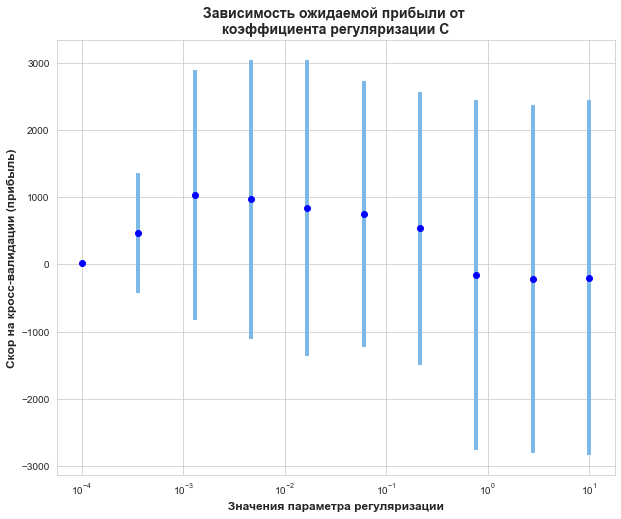

In [116]:
std_scores =  searcher.cv_results_['std_test_score']

plt.figure(figsize=(10, 8))
plt.errorbar(C_variations, searcher.cv_results_["mean_test_score"], yerr= std_scores,
             fmt='o', color='blue',
             ecolor='#7CB9E8', elinewidth=4, capsize=0
            )

plt.xscale("log")
plt.title("Зависимость ожидаемой прибыли от \nкоэффициента регуляризации C", fontsize = 14, fontweight='bold')
plt.xlabel('Значения параметра регуляризации',  fontsize=12, fontweight="bold")
plt.ylabel("Скор на кросс-валидации (прибыль)",  fontsize=12, fontweight="bold");


Доигрались, местами мы уходим в минус, хоть и  большая часть интервала положительная.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [123]:
%%time
best_params = []
best_scores = []

for _ in range(10):
    searcher = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": C_variations}], scoring=profit_maximization_scorer, cv=5)
    searcher.fit(X_cv, y)

    logreg_best_C = searcher.best_params_["C"]
    best_params.append(logreg_best_C )
   

    best_reg_score = searcher.best_score_
    best_scores.append(best_reg_score)

Wall time: 5min 12s


In [124]:
best_params

[0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884]

In [125]:
best_scores

[1006.0994459044089,
 1024.8101916884475,
 1044.5227527075333,
 1039.5564548565105,
 1045.5564035931807,
 1055.0067384834235,
 1022.9219887054882,
 1060.4242725078445,
 1008.2101609219965,
 1018.7208733072797]

Сложно увидеть различия между параметрами регуляризации, все примерно равно 0.0013. Скор тоже не сильно меняется, логично, так как логистической регресси не свойственно переобучение

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Скорее важен recall (полнота), чем precision, так как цена ошибки не так страшна, нужно отловить как можно больше объектов положительного класса



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [120]:
%%time
from sklearn.metrics import recall_score

grid = np.arange(0.0, 1.0, 0.01)
recalls_cv = []
X_cv = column_transformer.fit_transform(X)

for train_index, test_index in skf.split(X, y):
    recall_list = []
    for border in grid:
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)
        
        logreg = LogisticRegression(C=logreg_best_C, max_iter=100000, random_state=42).fit(X_train, y_train)
        
        probs = logreg.predict_proba(X_test)[:, 1]
        preds = np.array([1 if i > border else 0 for i in probs])
        
        recall = recall_score(y_test, preds)
        recall_list.append(recall)
    recalls_cv.append(recall_list)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [127]:
mean_cv = []
std_cv = []
for i in range(len(recalls_cv[0])):
    sum = 0
    recall_values = []
    for j in range(len(recalls_cv)):
        recall_values.append(recalls_cv[j][i])
    mean = np.mean(np.array(recall_values))
    std = np.std(np.array(recall_values))
    mean_cv.append(mean)
    std_cv.append(std)

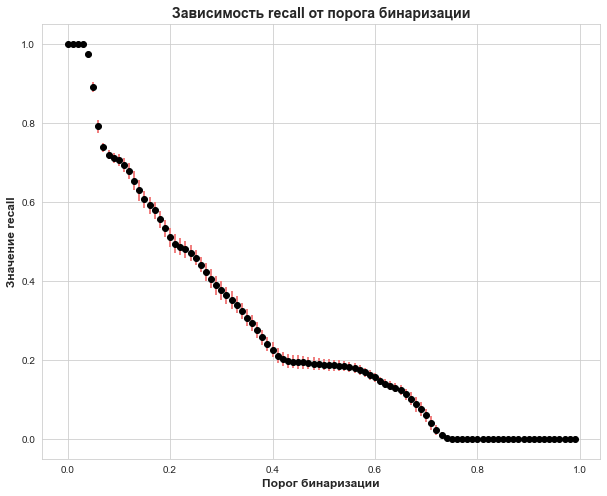

In [142]:
plt.figure(figsize=(10, 8))
plt.errorbar(grid, mean_cv, yerr=std_cv, fmt='o', color='black',
             ecolor='#F08080', elinewidth=2, capsize=0)

plt.title("Зависимость recall от порога бинаризации", fontsize = 14, fontweight='bold')
plt.ylabel("Значение recall",  fontsize = 12, fontweight = 'bold')
plt.xlabel( "Порог бинаризации", fontsize = 12, fontweight = 'bold');

In [137]:
print(grid[np.array(mean_cv) < 0.5])

[0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34
 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48
 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62
 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76
 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9
 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


In [186]:
%%time
grid = np.arange(0.0, 1.0, 0.01)
recalls_cv_prof = []
X_cv = column_transformer.fit_transform(X)

for train_index, test_index in skf.split(X, y):
    recalls_cv_buf = []
    for border in grid:
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)

        lr = LogisticRegression(C=logreg_best_C, max_iter=100000, random_state=13).fit(X_train, y_train)
        probs = lr.predict_proba(X_test)[:, 1]
        preds = np.array([1 if i > border else 0 for i in probs])

        score = profit_maximization(y_test, preds)
        recalls_cv_buf.append(score)

    recalls_cv_prof.append(recalls_cv_buf)

Wall time: 2min 1s


In [190]:
grid = np.arange(0.0, 1.0, 0.01)
recall_profit = []
X_cv = column_transformer.fit_transform(X)

for train_index, test_index in skf.split(X, y):
    recalls_cv_values = []
    for border in grid:
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)

        logreg = LogisticRegression(C=logreg_best_C, max_iter=100000, random_state=13).fit(X_train, y_train)
        probs = logreg.predict_proba(X_test)[:, 1]
        preds = np.array([1 if i > border else 0 for i in probs])

        score = profit_maximization(y_test, preds)
        recalls_cv_values.append(score)

    recall_profit.append(recalls_cv_values)

In [192]:
mean_profit_cv = []
std_profit_cv = []

for j in range(len(recall_profit[0])):
    recall_flatten = []
    for i in range(len(recall_profit)):
        recall_flatten.append(recall_profit[i][j])
    mean = np.mean(np.array(recall_flatten))
    std = np.std(np.array(recall_flatten))
    mean_profit_cv.append(mean)
    std_profit_cv.append(std)


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

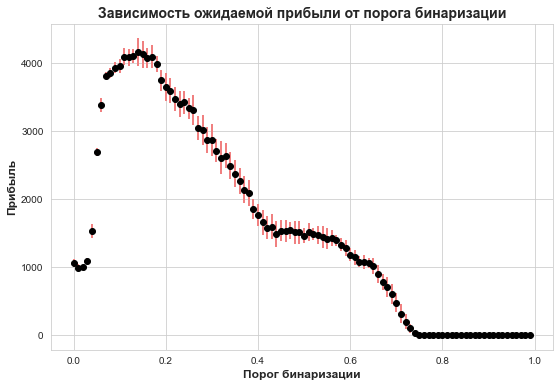

In [195]:


plt.figure(figsize=(9, 6))
plt.errorbar(grid, mean_profit_cv, yerr=std_profit_cv, fmt='o', color='black',
             ecolor='#F08080', elinewidth=2, capsize=0)
plt.title('Зависимость ожидаемой прибыли от порога бинаризации', fontsize=14, fontweight = 'bold')
plt.xlabel("Порог бинаризации", fontsize=12, fontweight = 'bold')
plt.ylabel("Прибыль", fontsize=12, fontweight = 'bold');

In [201]:
idx = np.argmax(mean_profit_cv)
print('Лучший порог равен:', grid[idx])

Лучший порог равен: 0.14


__Ответ:__ При приближении порога бинаризации к 0.8 наша прибыль выходит на плато с нулем. А максимальное значения прибыли достигается при пороге 0.14. В то же время диапозон лежит примерно от 0.12 до 0.15. То есть на этом промежутке мы достигаем баланса между желанием учесть как можно больше объектов положиельного класса и нежеланием обзванивать всех клиентов ( и платить все операторам)

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [203]:
border = 0.14
edge = 0.14
recall_edge_cv = []
precision_cv_edge = []
X_cv = column_transformer.fit_transform(X)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)

    logreg = LogisticRegression(C=logreg_best_C, max_iter=100000, random_state=42).fit(X_train, y_train)
    probs = logreg.predict_proba(X_test)[:, 1]
    preds = np.array([1 if i > edge else 0 for i in probs])

    score = profit_maximization(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)

    precision_cv_edge.append(precision)
    recall_edge_cv.append(recall)

In [207]:
mean_precision_edge = np.mean(np.array(precision_cv_edge))
mean_recall_edge = np.mean(np.array(recall_edge_cv))

std_precision_edge = np.std(np.array(precision_cv_edge))
std_recall_edge  = np.std(np.array(recall_edge_cv))

print("Пороговое значение", edge)
print("Среднее значение precision", mean_precision_edge)
print("Стандартное отклонение precision", std_precision_edge)

print("Среднее значение recall", mean_recall_edge)
print("Стандартное отклонение recall", std_recall_edge)


Пороговое значение 0.14
Среднее значение precision 0.34402090064725327
Стандартное отклонение precision 0.006187413123797701
Среднее значение recall 0.6288793103448276
Стандартное отклонение recall 0.025533108999344634


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [145]:
logreg= LogisticRegression(C=logreg_best_C, max_iter=100000, random_state=40).fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:, 1]

AUC-PR: 0.43616


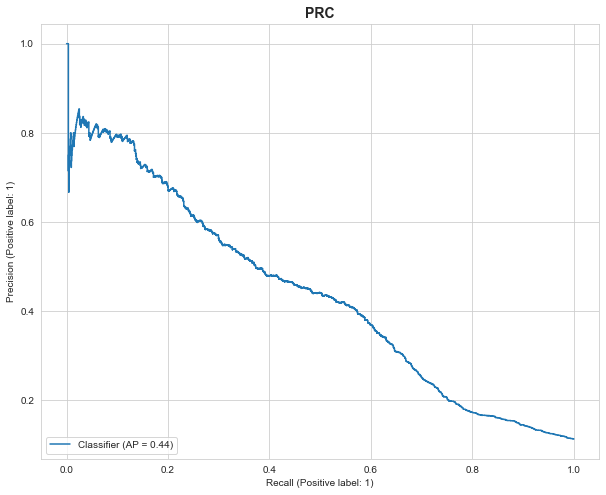

In [149]:
print('AUC-PR:', round( auc(recall, precision), 5 ))
fig, ax = plt.subplots(figsize=(10, 8))

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.title("PRC", fontsize=14, fontweight = 'bold');


Площадь равна 0.43616. Помотрим на сокращенную прямую

In [150]:
recall_cut = recall[recall >= 0.5]
precision_cut = precision[recall >= 0.5]

auc(recall_cut, precision_cut)

0.12156996951151502

In [151]:
from sklearn.preprocessing import MinMaxScaler

MinMax = MinMaxScaler() 

Поиграемся с единичным квадратом

In [156]:
MinMaxRecall = MinMax.fit_transform(recall_cut.reshape(-1, 1))
MinMaxPrecision = MinMax.fit_transform(precision_cut.reshape(-1, 1))
print(round(auc(MinMaxRecall, MinMaxPrecision),4))

0.3986


AUC PR у единичного квадрата тоже почти равен 0.4